In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
from tqdm import tqdm

%matplotlib inline

In [2]:
def getdata(sample_size, case=1, seed=None):
    
    if seed is not None:
        np.random.seed(seed)
    

    X = np.random.uniform(low=-1, high=1, size=(sample_size, 5))
    A = np.random.choice([0, 1], size=(sample_size, 2))

    if case == 1 or 2:
        mu = 10 + 5 * X[:, 0] + 3 * X[:, 1] + 2 * X[:, 2] - X[:, 4]
    elif case == 3 or 4:
        mu = 10 + np.exp(X[:, 0] + 2 * X[:, 1]) + np.abs(X[:, 3])

    alpha_ = np.zeros((sample_size, 5))

    for i in range(sample_size):

        if (A[i, :] == np.array([0, 0])).all():

            alpha_[i, :] = np.array([0, 2, -1, -4, 2])

        elif (A[i, :] == np.array([1, 0])).all():

            alpha_[i, :] = np.array([1, -2, 3, 1, 1])
        
        elif (A[i, :] == np.array([0, 1])).all():

            alpha_[i, :] = np.array([2, 3, 2, 0, -2])

        elif (A[i, :] == np.array([1, 1])).all():

            alpha_[i, :] = np.array([-3, -3, -4, 3, -1])

    beta_ = np.zeros((sample_size, 5))

    beta_[:, 0] = X[:, 0] ** 2 + X[:, 1] ** 2 - 1
    beta_[:, 1] = np.sin(- (X[:, 1] + X[:, 2]) * np.pi)
    beta_[:, 2] = np.log(1 + X[:, 3] ** 2 + X[:, 4] ** 2)
    beta_[:, 3] = 1 / (2 + X[:, 4])
    beta_[:, 4] = np.exp(- X[:, 2] * X[:, 4])

    if case == 1:

        R = mu + np.sum(np.multiply(alpha_, X), axis=1) + np.random.normal(size=(sample_size, ))

    elif case == 2:

        R = mu + np.sum(np.multiply(alpha_, beta_), axis=1) + np.random.normal(size=(sample_size, ))

    elif case == 3:

        R = mu + np.sum(np.multiply(alpha_, X), axis=1) + np.random.normal(size=(sample_size, ))

    elif case == 4:

        R = mu + np.sum(np.multiply(alpha_, beta_), axis=1) + np.random.normal(size=(sample_size, ))

    return R, X, A



In [3]:
def evalITR(Y, A, D):

    numerator = np.sum(Y[np.all(D == A, axis=1)])
    denominator = np.sum(np.all(D == A, axis=1))
    
    return numerator / denominator

In [4]:
# Simulation 1

embed_list = np.zeros((100, 4, 5))
vals_list = np.zeros((100, ))

for i in tqdm(range(100)):

    R_train, X_train, A_train = getdata(500)
    R_test, X_test, A_test = getdata(10000)

    mcitr = MCITR(layer_enc=4, layer_dec=4, layer_cov=0,
                  act_enc="relu", act_dec="relu",
                  width_enc=20, width_dec=20, optimizer="adam")

    mcitr.fit(R_train, X_train, A_train, learning_rate=1e-2, epochs=100)

    embed_list[i, 0] = mcitr.trt_encoder.predict(np.array([[0, 0]]))
    embed_list[i, 1] = mcitr.trt_encoder.predict(np.array([[1, 0]]))
    embed_list[i, 2] = mcitr.trt_encoder.predict(np.array([[0, 1]]))
    embed_list[i, 3] = mcitr.trt_encoder.predict(np.array([[1, 1]]))
    
    D_test = mcitr.predict(X_test, A_test)

    vals_list[i] = evalITR(R_test, A_test, D_test)

np.save("case1_embedding", embed_list)
np.save("case1_value", vals_list)

100%|██████████████████████████████████████████████████| 100/100 [03:23<00:00,  2.04s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x28c8acef4f0>,
 'caps': [<matplotlib.lines.Line2D at 0x28c8acefc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c8acef160>,
 'medians': [<matplotlib.lines.Line2D at 0x28c89944370>,
 'fliers': [<matplotlib.lines.Line2D at 0x28c89944700>,
 'means': []}

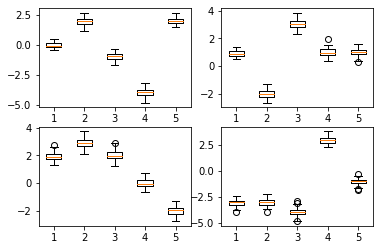

In [5]:
embed_list = np.load("case1_embedding.npy")

fig, ax = plt.subplots(2, 2)

ax[0, 0].boxplot(embed_list[:, 0, :])
ax[0, 1].boxplot(embed_list[:, 1, :])
ax[1, 0].boxplot(embed_list[:, 2, :])
ax[1, 1].boxplot(embed_list[:, 3, :])

In [6]:
# Simulation 2

embed_list = np.zeros((100, 4, 5))
vals_list = np.zeros((100, ))

for i in tqdm(range(100)):

    R_train, X_train, A_train = getdata(500, case=2)
    R_test, X_test, A_test = getdata(10000, case=2)

    mcitr = MCITR(layer_enc=4, layer_dec=4, layer_cov=0,
                  act_enc="relu", act_dec="relu", 
                  width_enc=20, width_dec=20, optimizer="adam")

    mcitr.fit(R_train, X_train, A_train, learning_rate=1e-2, epochs=100)

    embed_list[i, 0] = mcitr.trt_encoder.predict(np.array([[0, 0]]))
    embed_list[i, 1] = mcitr.trt_encoder.predict(np.array([[1, 0]]))
    embed_list[i, 2] = mcitr.trt_encoder.predict(np.array([[0, 1]]))
    embed_list[i, 3] = mcitr.trt_encoder.predict(np.array([[1, 1]]))
    
    D_test = mcitr.predict(X_test, A_test)

    vals_list[i] = evalITR(R_test, A_test, D_test)

np.save("case2_embedding", embed_list)
np.save("case2_value", vals_list)

100%|██████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.05s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x28c8851d6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x28c8851db80>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c880fb100>,
 'medians': [<matplotlib.lines.Line2D at 0x28c8988e5e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x28c8988e7c0>,
 'means': []}

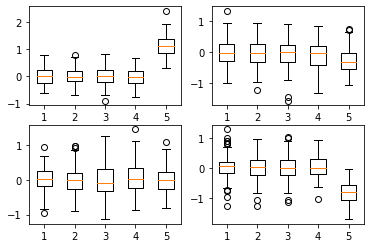

In [7]:
embed_list = np.load("case2_embedding.npy")

fig, ax = plt.subplots(2, 2)

ax[0, 0].boxplot(embed_list[:, 0, :])
ax[0, 1].boxplot(embed_list[:, 1, :])
ax[1, 0].boxplot(embed_list[:, 2, :])
ax[1, 1].boxplot(embed_list[:, 3, :])


In [8]:
# Simulation 3

embed_list = np.zeros((100, 4, 5))
vals_list = np.zeros((100, ))

for i in tqdm(range(100)):

    R_train, X_train, A_train = getdata(500, case=3)
    R_test, X_test, A_test = getdata(10000, case=3)

    mcitr = MCITR(layer_enc=4, layer_dec=4, layer_cov=0,
                  act_enc="relu", act_dec="relu", 
                  width_enc=20, width_dec=20, optimizer="adam")

    mcitr.fit(R_train, X_train, A_train, learning_rate=1e-2, epochs=100)

    embed_list[i, 0] = mcitr.trt_encoder.predict(np.array([[0, 0]]))
    embed_list[i, 1] = mcitr.trt_encoder.predict(np.array([[1, 0]]))
    embed_list[i, 2] = mcitr.trt_encoder.predict(np.array([[0, 1]]))
    embed_list[i, 3] = mcitr.trt_encoder.predict(np.array([[1, 1]]))
    
    D_test = mcitr.predict(X_test, A_test)

    vals_list[i] = evalITR(R_test, A_test, D_test)

np.save("case3_embedding", embed_list)
np.save("case3_value", vals_list)

100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x28c88245af0>,
 'caps': [<matplotlib.lines.Line2D at 0x28c8b17b250>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c88245760>,
 'medians': [<matplotlib.lines.Line2D at 0x28c8b17b970>,
 'fliers': [<matplotlib.lines.Line2D at 0x28c8b17bd00>,
 'means': []}

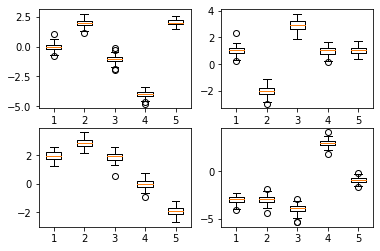

In [9]:
embed_list = np.load("case3_embedding.npy")

fig, ax = plt.subplots(2, 2)

ax[0, 0].boxplot(embed_list[:, 0, :])
ax[0, 1].boxplot(embed_list[:, 1, :])
ax[1, 0].boxplot(embed_list[:, 2, :])
ax[1, 1].boxplot(embed_list[:, 3, :])


In [10]:
# Simulation 4

embed_list = np.zeros((100, 4, 5))
vals_list = np.zeros((100, ))

for i in tqdm(range(100)):

    R_train, X_train, A_train = getdata(500, case=4)
    R_test, X_test, A_test = getdata(10000, case=4)

    mcitr = MCITR(layer_enc=4, layer_dec=4, layer_cov=0,
                  act_enc="relu", act_dec="relu",
                  width_enc=20, width_dec=20, optimizer="adam")

    mcitr.fit(R_train, X_train, A_train, learning_rate=1e-2, epochs=100)

    embed_list[i, 0] = mcitr.trt_encoder.predict(np.array([[0, 0]]))
    embed_list[i, 1] = mcitr.trt_encoder.predict(np.array([[1, 0]]))
    embed_list[i, 2] = mcitr.trt_encoder.predict(np.array([[0, 1]]))
    embed_list[i, 3] = mcitr.trt_encoder.predict(np.array([[1, 1]]))
    
    D_test = mcitr.predict(X_test, A_test)

    vals_list[i] = evalITR(R_test, A_test, D_test)

np.save("case4_embedding", embed_list)
np.save("case4_value", vals_list)

100%|██████████████████████████████████████████████████| 100/100 [03:19<00:00,  2.00s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x28c8d562310>,
 'caps': [<matplotlib.lines.Line2D at 0x28c8d562a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x28c8d560f40>,
 'medians': [<matplotlib.lines.Line2D at 0x28c8d81d190>,
 'fliers': [<matplotlib.lines.Line2D at 0x28c8d81d520>,
 'means': []}

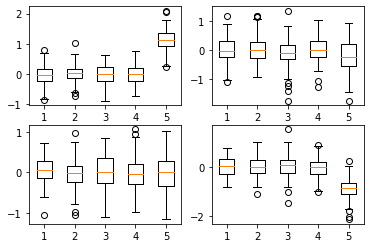

In [11]:
embed_list = np.load("case4_embedding.npy")

fig, ax = plt.subplots(2, 2)

ax[0, 0].boxplot(embed_list[:, 0, :])
ax[0, 1].boxplot(embed_list[:, 1, :])
ax[1, 0].boxplot(embed_list[:, 2, :])
ax[1, 1].boxplot(embed_list[:, 3, :])
